## Exendend tests on processing time w.r.t number of dem pixel

This workbook tests (i) the processing time of the geometric corrections and (ii) the radiometric corrections of the terrain against the number of points in the input DEM.
We will use a 10-meter DEM resampled at 5 meter, 10 meter, 20 meter, 30 meter.

As an example, we use data convering the South-of-Redmond region (Seattle, US). Both the input GRD and DEM will be downloaded from the Planatery Computer.

**Note**: Download/retrieval steps are slower on local machines compared to the Planetary Computer. In future versions, it will be possible to access data via [fsspec](https://filesystem-spec.readthedocs.io/en/latest/) without having to download data locally.

<hr style="border:2px solid blue"> </hr>

### Install Dependencies and Import
Additional dependecies: `sarsen`

In [1]:
!pip install -q sarsen

In [2]:
!pip install -U memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=78eb751e4528ba78e9acba2315763b8fc0f00c56f214bb8be8292fe0e949346c
  Stored in directory: /home/jovyan/.cache/pip/wheels/01/ca/8b/b518dd2aef69635ad6fcab87069c9c52f355a2e9c5d4c02da9
Successfully built memory-profiler


In [27]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size': 22})

%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [25]:
import os
import tempfile
import time

# enable the `.rio` accessor
import rioxarray  # noqa: F401
import xarray as xr

from sarsen import apps, geocoding, radiometry

In [5]:
import adlfs
import planetary_computer
import pystac_client
import stackstac

### Processing definitions

In [6]:
# create a temporary directory where to store downloaded data
tmp_dir = tempfile.gettempdir()

# DEM path
dem_05_path = os.path.join(tmp_dir, "South-of-Redmond-05.tif")

# path to Sentinel-1 input product in the Planetary Computer
product_folder = "GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048"  # noqa: E501

# band to be processed
measurement_group = "IW/VV"

tmp_dir

'/tmp'

#### Area of interest definition: South-of-Redmond (Seattle, US)

In [7]:
lon, lat = [-121.95, 47.04]
buffer = 0.2
bbox = [lon - buffer, lat - buffer, lon + buffer, lat + buffer]

#### DEMs discovery

Here we use the DEM with a 10-meter ground sample distance (GDS) available on the Planetary Computer. Note that **any DEM supported by GDAL/Proj can be used**.

Using `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.  
As multiple DEMs acquired at different times are available in this area, we select the DEMs with 10-meter GDS and perform the average of the remaining DEMs along the time dimension.

In [8]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
search = catalog.search(collections="3dep-seamless", bbox=bbox)
items = list(search.get_items())

Here we load the data into an xarray `DataArray` using stackstac.

In [9]:
# select DEMs with resolution 10 meters
items_high_res = [
    planetary_computer.sign(item).to_dict()
    for item in items
    if item.properties["gsd"] == 10
]

dem_raster_all = stackstac.stack(items_high_res, bounds=bbox).squeeze()
dem_raster_all


/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))


<xarray.DataArray 'stackstac-2a2c800ed83b351194fa1d3890f182f1' (time: 4,
                                                                y: 4321, x: 4321)>
dask.array<getitem, shape=(4, 4321, 4321), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time             (time) datetime64[ns] 2018-02-02 2018-02-08 ... 2020-01-07
    id               (time) <U10 'n48w122-13' 'n47w123-13' ... 'n48w123-13'
    band             <U4 'data'
  * x                (x) float64 -122.2 -122.1 -122.1 ... -121.8 -121.8 -121.8
  * y                (y) float64 47.24 47.24 47.24 47.24 ... 46.84 46.84 46.84
    proj:shape       object {10812}
    ...               ...
    threedep:region  <U7 'n40w130'
    proj:epsg        int64 5498
    gsd              int64 10
    end_datetime     (time) <U20 '2016-12-31T00:00:00Z' ... '2019-04-25T00:00...
    description      <U1849 'This tile of the 3D Elevation Program (3DEP) sea...
    epsg             int64 5498
Attributes:
    spec:        RasterSpec(epsg=5498, bounds=(-122.15000053746, 46.839907613...
    crs:         epsg:5498
    transform:   | 0.00, 0.00,-122.15|\n| 0.00,-0.00, 47.24|\n| 0.00, 0.00, 1...
    resolution:  9.2592593e-05

#### DEMs average along the time dimension

In [10]:
dem_raster_geo = dem_raster_all.compute()
if "time" in dem_raster_geo.dims:
    dem_raster_geo = dem_raster_geo.mean("time")
_ = dem_raster_geo.rio.set_crs(dem_raster_all.rio.crs)

#### Convert the DEM in UTM coordinates and resample

In order to facilitate the comparison between the RTC computed by sarsen with the RTC available on the Planetery Computer, here we convert the DEM in UTM.

In [11]:
dem_raster_geo

<xarray.DataArray 'stackstac-2a2c800ed83b351194fa1d3890f182f1' (y: 4321, x: 4321)>
array([[ 163.69631958,  162.63404846,  162.2134552 , ...,  663.19958496,
         660.66424561,  658.06341553],
       [ 163.07417297,  162.64425659,  162.26867676, ...,  665.82775879,
         663.2644043 ,  660.68115234],
       [ 163.33903503,  162.73181152,  162.52307129, ...,  668.45983887,
         665.91448975,  663.2935791 ],
       ...,
       [ 497.75076294,  498.00402832,  498.57537842, ..., 3596.11181641,
        3595.29345703, 3594.25097656],
       [ 499.36859131,  499.1661377 ,  499.65731812, ..., 3591.16503906,
        3590.3659668 , 3590.12866211],
       [ 500.57394409,  500.69110107,  501.01998901, ..., 3585.75805664,
        3571.08642578, 3562.89208984]])
Coordinates:
    band             <U4 'data'
  * x                (x) float64 -122.2 -122.1 -122.1 ... -121.8 -121.8 -121.8
  * y                (y) float64 47.24 47.24 47.24 47.24 ... 46.84 46.84 46.84
    proj:shape       object {10812}
    threedep:region  <U7 'n40w130'
    proj:epsg        int64 5498
    gsd              int64 10
    description      <U1849 'This tile of the 3D Elevation Program (3DEP) sea...
    epsg             int64 5498

In [12]:
# find the UTM zone and project in UTM
# crop DEM to our area of interest and save it
dem_corners = dict(x=slice(569000, 594000), y=slice(5220000, 5200000))

t_srs = dem_raster_geo.rio.estimate_utm_crs()

dem_raster_05 = dem_raster_geo.rio.reproject(t_srs, resolution=(5, 5))
dem_raster_05 = dem_raster_05.sel(**dem_corners)


In [13]:
#  save dem at different resolutions
dem_raster_05.rio.to_raster(dem_05_path)

Text(0.5, 1.0, 'DEM UTM 30m')

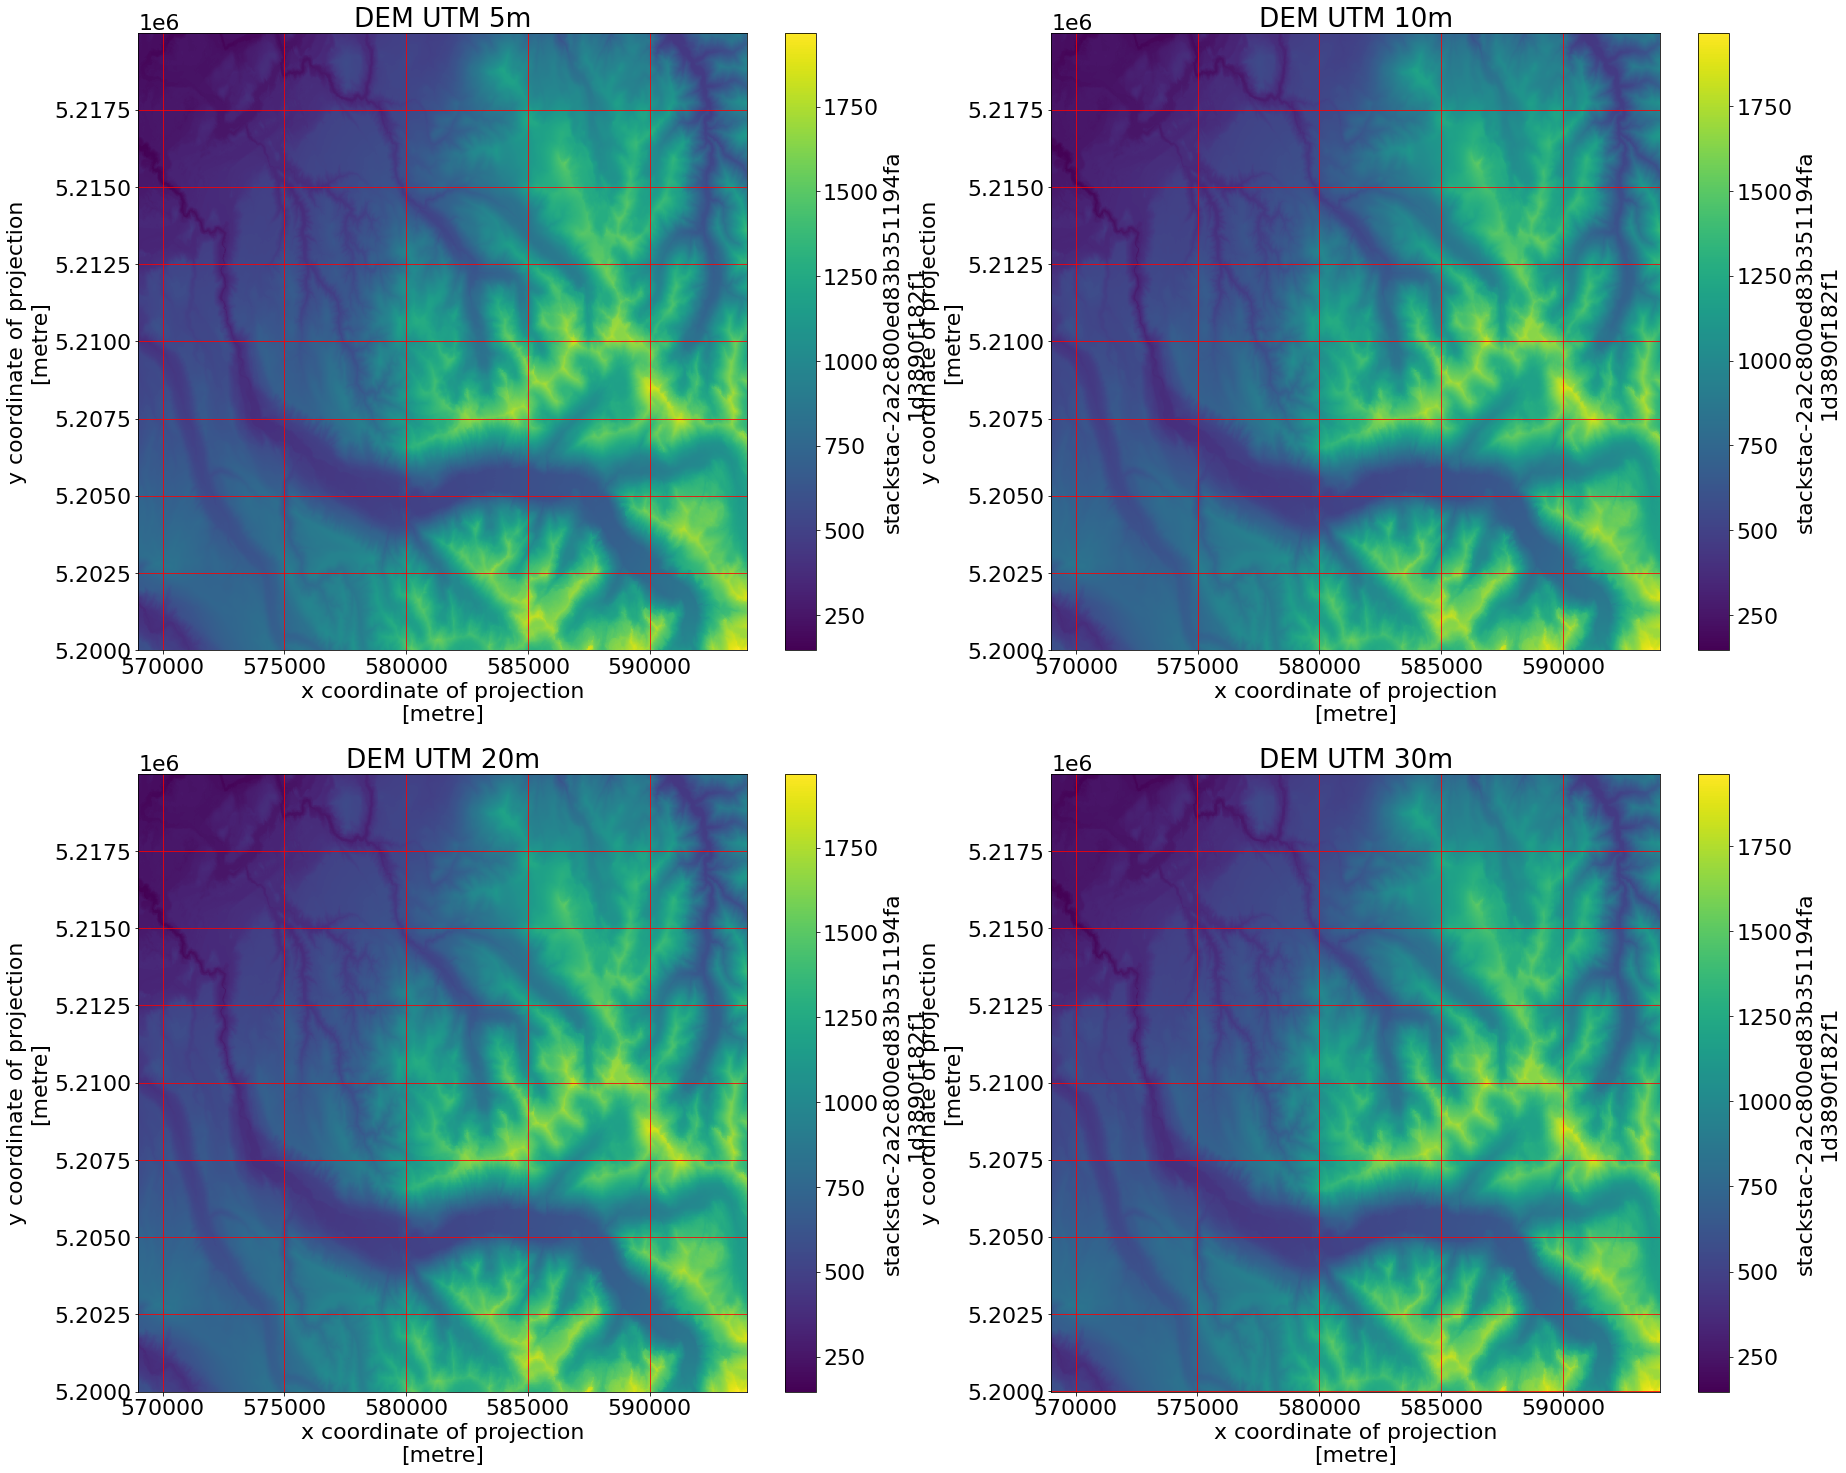

In [14]:
dem_raster_05.plot()
_ = plt.title("DEM in UTM coordinates")

### Define GRD parameters

In [15]:
grd_account_name = "sentinel1euwest"
grd_storage_container = "s1-grd"
grd_product_folder = f"{grd_storage_container}/{product_folder}"
grd_local_path = os.path.join(tmp_dir, product_folder)

### Retrieve Sentinel-1 GRD

In [16]:
grd_token = planetary_computer.sas.get_token(
    grd_account_name, grd_storage_container
).token
grd_fs = adlfs.AzureBlobFileSystem(grd_account_name, credential=grd_token)
grd_fs.ls(f"{grd_product_folder}/manifest.safe")

['s1-grd/GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048/manifest.safe']

In [17]:
grd_fs.get(grd_product_folder, grd_local_path, recursive=True)
!ls -d {grd_local_path}

/tmp/GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048


### Processing

#### GTC

In [24]:
kargs = dict(
    product_urlpath=grd_local_path, 
    measurement_group=measurement_group, 
    dem_urlpath=dem_05_path, 
    output_urlpath=os.path.join(tmp_dir, os.path.basename(product_folder) + ".05m.GTC.tif")
)

%mprun -f geocoding.backward_geocode apps.terrain_correction(**kargs)

Filename: /srv/conda/envs/notebook/lib/python3.8/site-packages/sarsen/geocoding.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    70   4507.5 MiB   4507.5 MiB           1   def backward_geocode(
    71                                             dem_ecef: xr.DataArray,
    72                                             position_ecef: xr.DataArray,
    73                                             velocity_ecef: xr.DataArray,
    74                                             azimuth_time: T.Optional[xr.DataArray] = None,
    75                                             dim: str = "axis",
    76                                             diff_ufunc: float = 1.0,
    77                                         ) -> xr.Dataset:
    78   4507.5 MiB      0.0 MiB           1       direction_ecef = (
    79   4507.5 MiB      0.0 MiB           1           velocity_ecef / xr.dot(velocity_ecef, velocity_ecef, dims=dim) ** 0.5  # type: ignore
    80                         

#### RTC

In [28]:
kargs = dict(
    product_urlpath=grd_local_path, 
    measurement_group=measurement_group, 
    dem_urlpath=dem_05_path, 
    correct_radiometry="gamma_bilinear",
    output_urlpath=os.path.join(tmp_dir, os.path.basename(product_folder) + ".05m.GTC.tif")
)

%mprun -f radiometry.gamma_weights_bilinear apps.terrain_correction(**kargs)

Filename: /srv/conda/envs/notebook/lib/python3.8/site-packages/sarsen/radiometry.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    66   8547.9 MiB   8547.9 MiB           1   def gamma_weights_bilinear(
    67                                             dem_ecef: xr.DataArray,
    68                                             dem_coords: xr.Dataset,
    69                                             slant_range_time0: float,
    70                                             azimuth_time0: np.datetime64,
    71                                             slant_range_time_interval_s: float,
    72                                             azimuth_time_interval_s: float,
    73                                             slant_range_spacing_m: float = 1,
    74                                             azimuth_spacing_m: float = 1,
    75                                         ) -> xr.DataArray:
    76                                         
    77   8700.5 MiB 

In [29]:
kargs = dict(
    product_urlpath=grd_local_path, 
    measurement_group=measurement_group, 
    dem_urlpath=dem_05_path, 
    correct_radiometry="gamma_bilinear",
    output_urlpath=os.path.join(tmp_dir, os.path.basename(product_folder) + ".05m.GTC.tif")
)

%mprun -f radiometry.sum_weights apps.terrain_correction(**kargs)

Filename: /srv/conda/envs/notebook/lib/python3.8/site-packages/sarsen/radiometry.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    14  11011.4 MiB  -8607.2 MiB           4   def sum_weights(
    15                                             initial_weights: xr.DataArray,
    16                                             azimuth_index: xr.DataArray,
    17                                             slant_range_index: xr.DataArray,
    18                                             multilook: T.Optional[T.Tuple[int, int]] = None,
    19                                         ) -> xr.DataArray:
    20  11011.4 MiB      0.0 MiB           8       geocoded = initial_weights.assign_coords(
    21  11011.4 MiB      0.0 MiB           4           slant_range_index=slant_range_index, azimuth_index=azimuth_index
    22                                             )  # type: ignore
    23                                         
    24  11354.9 MiB      0.0 MiB           4   

In [32]:
dem_raster_05.shape

(4000, 5000)